### Here is contained all data processing code for my master Thesis

In [55]:
import re,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns
pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'received_s: (\d+) received_ns: (\d+)'

base_dir=os.path.join("data/transport/100shotv5/")


# get difference in timespec
def timespec_difference(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

- boxplot
- metrics in S
- check consistency of all data

## Retrive data

In [56]:
protocols = ["udp", "udpM", "shm", "tcp"] #For now considering only udp

sent_data = defaultdict(list)
received_data =defaultdict(list)
sent_data_dummy = []
received_data_dummy = []


for prots in protocols:
    # Pub part
    file_path= os.path.join(base_dir,f'pub_{prots}_0.data')
    with open(file_path, 'r') as file: 
            for line in file:
                match = re.search(pub_pattern, line)
                if match:
                    cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                    sent_data[prots].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
    # Sub part
    for j in range(48):
        if prots == "shm" and j == 47: continue
        file_path= os.path.join(base_dir,f'sub_{prots}_{j}.data')
        with open(file_path, 'r') as file: 
            for line_n,content in enumerate(file):
                match = re.search(sub_pattern, content)
                if match:
                    received_s, received_ns = match.groups()
                    start_s,start_ns = ((sent_data[prots][line_n][2], sent_data[prots][line_n][3]))
                    s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                    received_data[prots].append((s_diff, ns_diff))


## Cleaning data

In [57]:
column_time = {}
# Convert data to timespec
for prots in received_data:
    list_difference=[]
    nlen= len(received_data[prots])
    for cycle_data in received_data[prots]:
        list_difference.append(cycle_data[0] + cycle_data[1] / 1e9) # time in second
    column_time[prots]=list_difference
    print(np.average(column_time[prots]))

# Remove outliers
column_time_cleaned = {}
for prots, data in column_time.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_cleaned[prots] = [x for x in data if lower_bound <= x <= upper_bound]

0.00014561440645833335
0.002759322896043771
0.02598709742962621
0.00010556489106382979


## Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

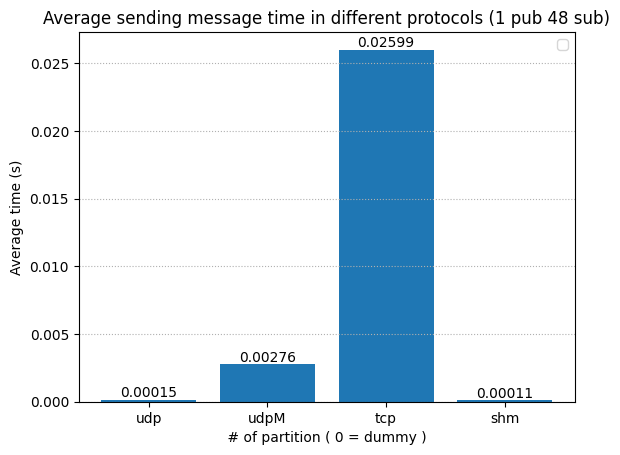

In [58]:
# Prepare data for bar plot
column_averages={}
for prots, data in column_time_cleaned.items():
    column_averages[prots] = np.average(column_time[prots])

bar_labels = protocols
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars= ax.bar(bar_labels,column_averages.values())
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (s)")
plt.legend()
plt.title("Average sending message time in different protocols (1 pub 48 sub)")
plt.grid(axis='y', linestyle=':')
plt.savefig(f"results/barplots_protocols_{base_dir.split('/')[2]}.png")

plt.show()

## Box Plot

maxlenght is 4800
Fixing dimension of :  udpM 4495 4800
Fixing dimension of :  tcp 3299 4800
Fixing dimension of :  shm 4618 4800
dict_keys(['udp', 'udpM', 'tcp', 'shm'])
data


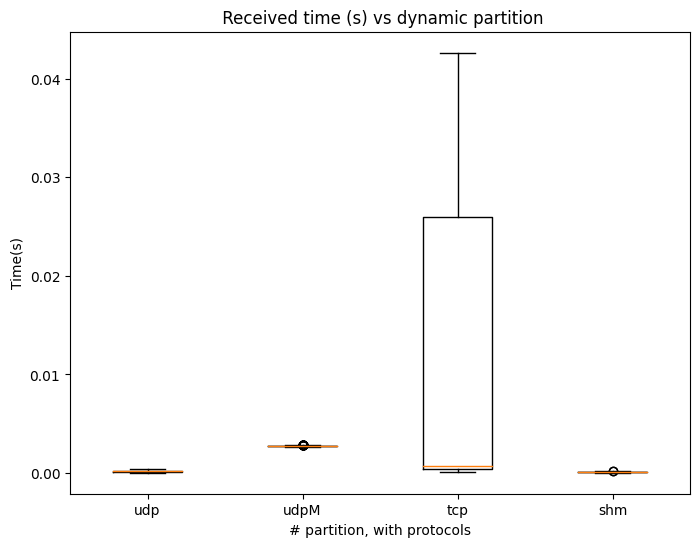

In [59]:
maxlenght = max(len(data) for data in column_time_cleaned.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time_cleaned.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time_cleaned[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time_cleaned.values(),data=column_time_cleaned.keys(),labels=protocols)
plt.title(" Received time (s) vs dynamic partition")
plt.xlabel("# partition, with protocols")
plt.ylabel("Time(s)")

print(column_time_cleaned.keys())

print(base_dir.split('/')[0])
plt.savefig(f"results/boxplot_protocols_{base_dir.split('/')[2]}.png")

plt.show()



uncleaned ones


maxlenght is 4800
Fixing dimension of :  udpM 4752 4800
Fixing dimension of :  tcp 4334 4800
Fixing dimension of :  shm 4700 4800
dict_keys(['udp', 'udpM', 'tcp', 'shm'])
data


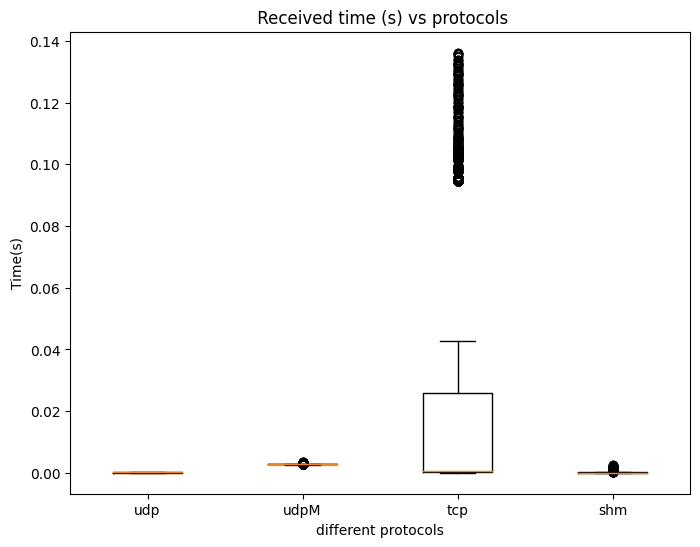

In [60]:
maxlenght = max(len(data) for data in column_time.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time.values(),data=column_time.keys(),labels=protocols)
plt.title(" Received time (s) vs protocols")
plt.xlabel("different protocols")
plt.ylabel("Time(s)")

print(column_time.keys())

print(base_dir.split('/')[0])
plt.show()

